In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import mode
from matplotlib import pyplot as plt
import seaborn as sns
from palettable.cartocolors.sequential import SunsetDark_6_r

## Data Validation

In [2]:
# change font sizes and whatnot
plt.rc("text", usetex=False)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)

In [45]:
chains = np.load("cnn/1-cyanonaphthalene/chain.npy")
# hurr = np.load("cnn/2-cyanonapthalene/third.npy")

# Rescale the column densities
chains[:,:,4:8] /= 1e11

# this bit of the code will reject some walkers because they haven't converged
# this is a problem for the column densities, where the plots are completely
# skewed because some walkers are extremely far away
interchain_mean = chains.mean(0)

posterior_mean = chains[-1000:,:,:].reshape(-1, 14).mean(0)
posterior_std = chains[-1000:,:,:].reshape(-1, 14).std(0)

# calculate how far the chains are from the mean
deviation = interchain_mean - posterior_mean[np.newaxis,:]

# Reject walkers that are too far from the ensemble means; here it's 3 sigma
threshold = deviation[:,4] <= posterior_std[5] * 1.

print(f"There are {threshold.sum()} remaining walkers.")

There are 99 remaining walkers.


In [47]:
# plt.plot(chains[-500:,threshold,4])

In [48]:
# take the last 500 samples from each walker
chains = chains[-500:,threshold,:].reshape(-1, 14)

# calculate the percentiles used throughout the paper
summary_stats = np.percentile(chains, [16, 50, 84], 0)

# 16th, 50th, and 84th percentile
summary_stats.shape

_ = np.random.seed(42)

In [49]:
summary_stats

array([[4.94431703e+01, 4.51675790e+01, 1.41194094e+02, 1.65107610e+02,
        1.34585889e+00, 2.15136707e+00, 8.15237787e-01, 2.00340079e+00,
        8.58126703e+00, 5.57404058e+00, 5.76277671e+00, 5.88579451e+00,
        6.01436099e+00, 1.16704755e-01],
       [9.80523860e+01, 8.59851379e+01, 2.33190088e+02, 2.57531704e+02,
        1.58567554e+00, 2.49032223e+00, 1.05106766e+00, 2.21958012e+00,
        8.94643742e+00, 5.58032113e+00, 5.76570915e+00, 5.89200794e+00,
        6.01759662e+00, 1.25924539e-01],
       [1.88060654e+02, 1.28026060e+02, 3.13844795e+02, 3.39083960e+02,
        1.95006736e+00, 3.16439094e+00, 1.26518445e+00, 2.44851482e+00,
        9.27347708e+00, 5.58717925e+00, 5.76848333e+00, 5.89821592e+00,
        6.02118919e+00, 1.35741649e-01]])

In [55]:
np.save("cnn/1-cyanonaphthalene/analyzed_chain.npy", chains)

In [50]:
# column names for each parameter
param_names = [
    r'Source Size #1 ["]',
    r'Source Size #2 ["]',
    r'Source Size #3 ["]',
    r'Source Size #4 ["]',
    r'N$_\mathrm{col}$ #1 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #2 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #3 [$10^{11}$ cm$^{-2}$]',
    r'N$_\mathrm{col}$ #4 [$10^{11}$ cm$^{-2}$]',
    r'T$_\mathrm{ex}$ [K]',
    r'V$_\mathrm{LSRK}$ #1 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #2 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #3 [km s$^{-1}$]',
    r'V$_\mathrm{LSRK}$ #4 [km s$^{-1}$]',
    r'dV [km s$^{-1}$]'
]

In [51]:
df = pd.DataFrame(
    chains,
    columns=param_names
)

# hacker statistics (not really)
# we don't need to use the full 20k samples to make plots, just take 1000 samples
# from the "posterior"
samples = df.sample(1000, replace=True)

In [52]:
top_color, bottom_color = SunsetDark_6_r.hex_colors[0], SunsetDark_6_r.hex_colors[-1]

/home/kelvin/anaconda3/envs/astro_mcmc/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


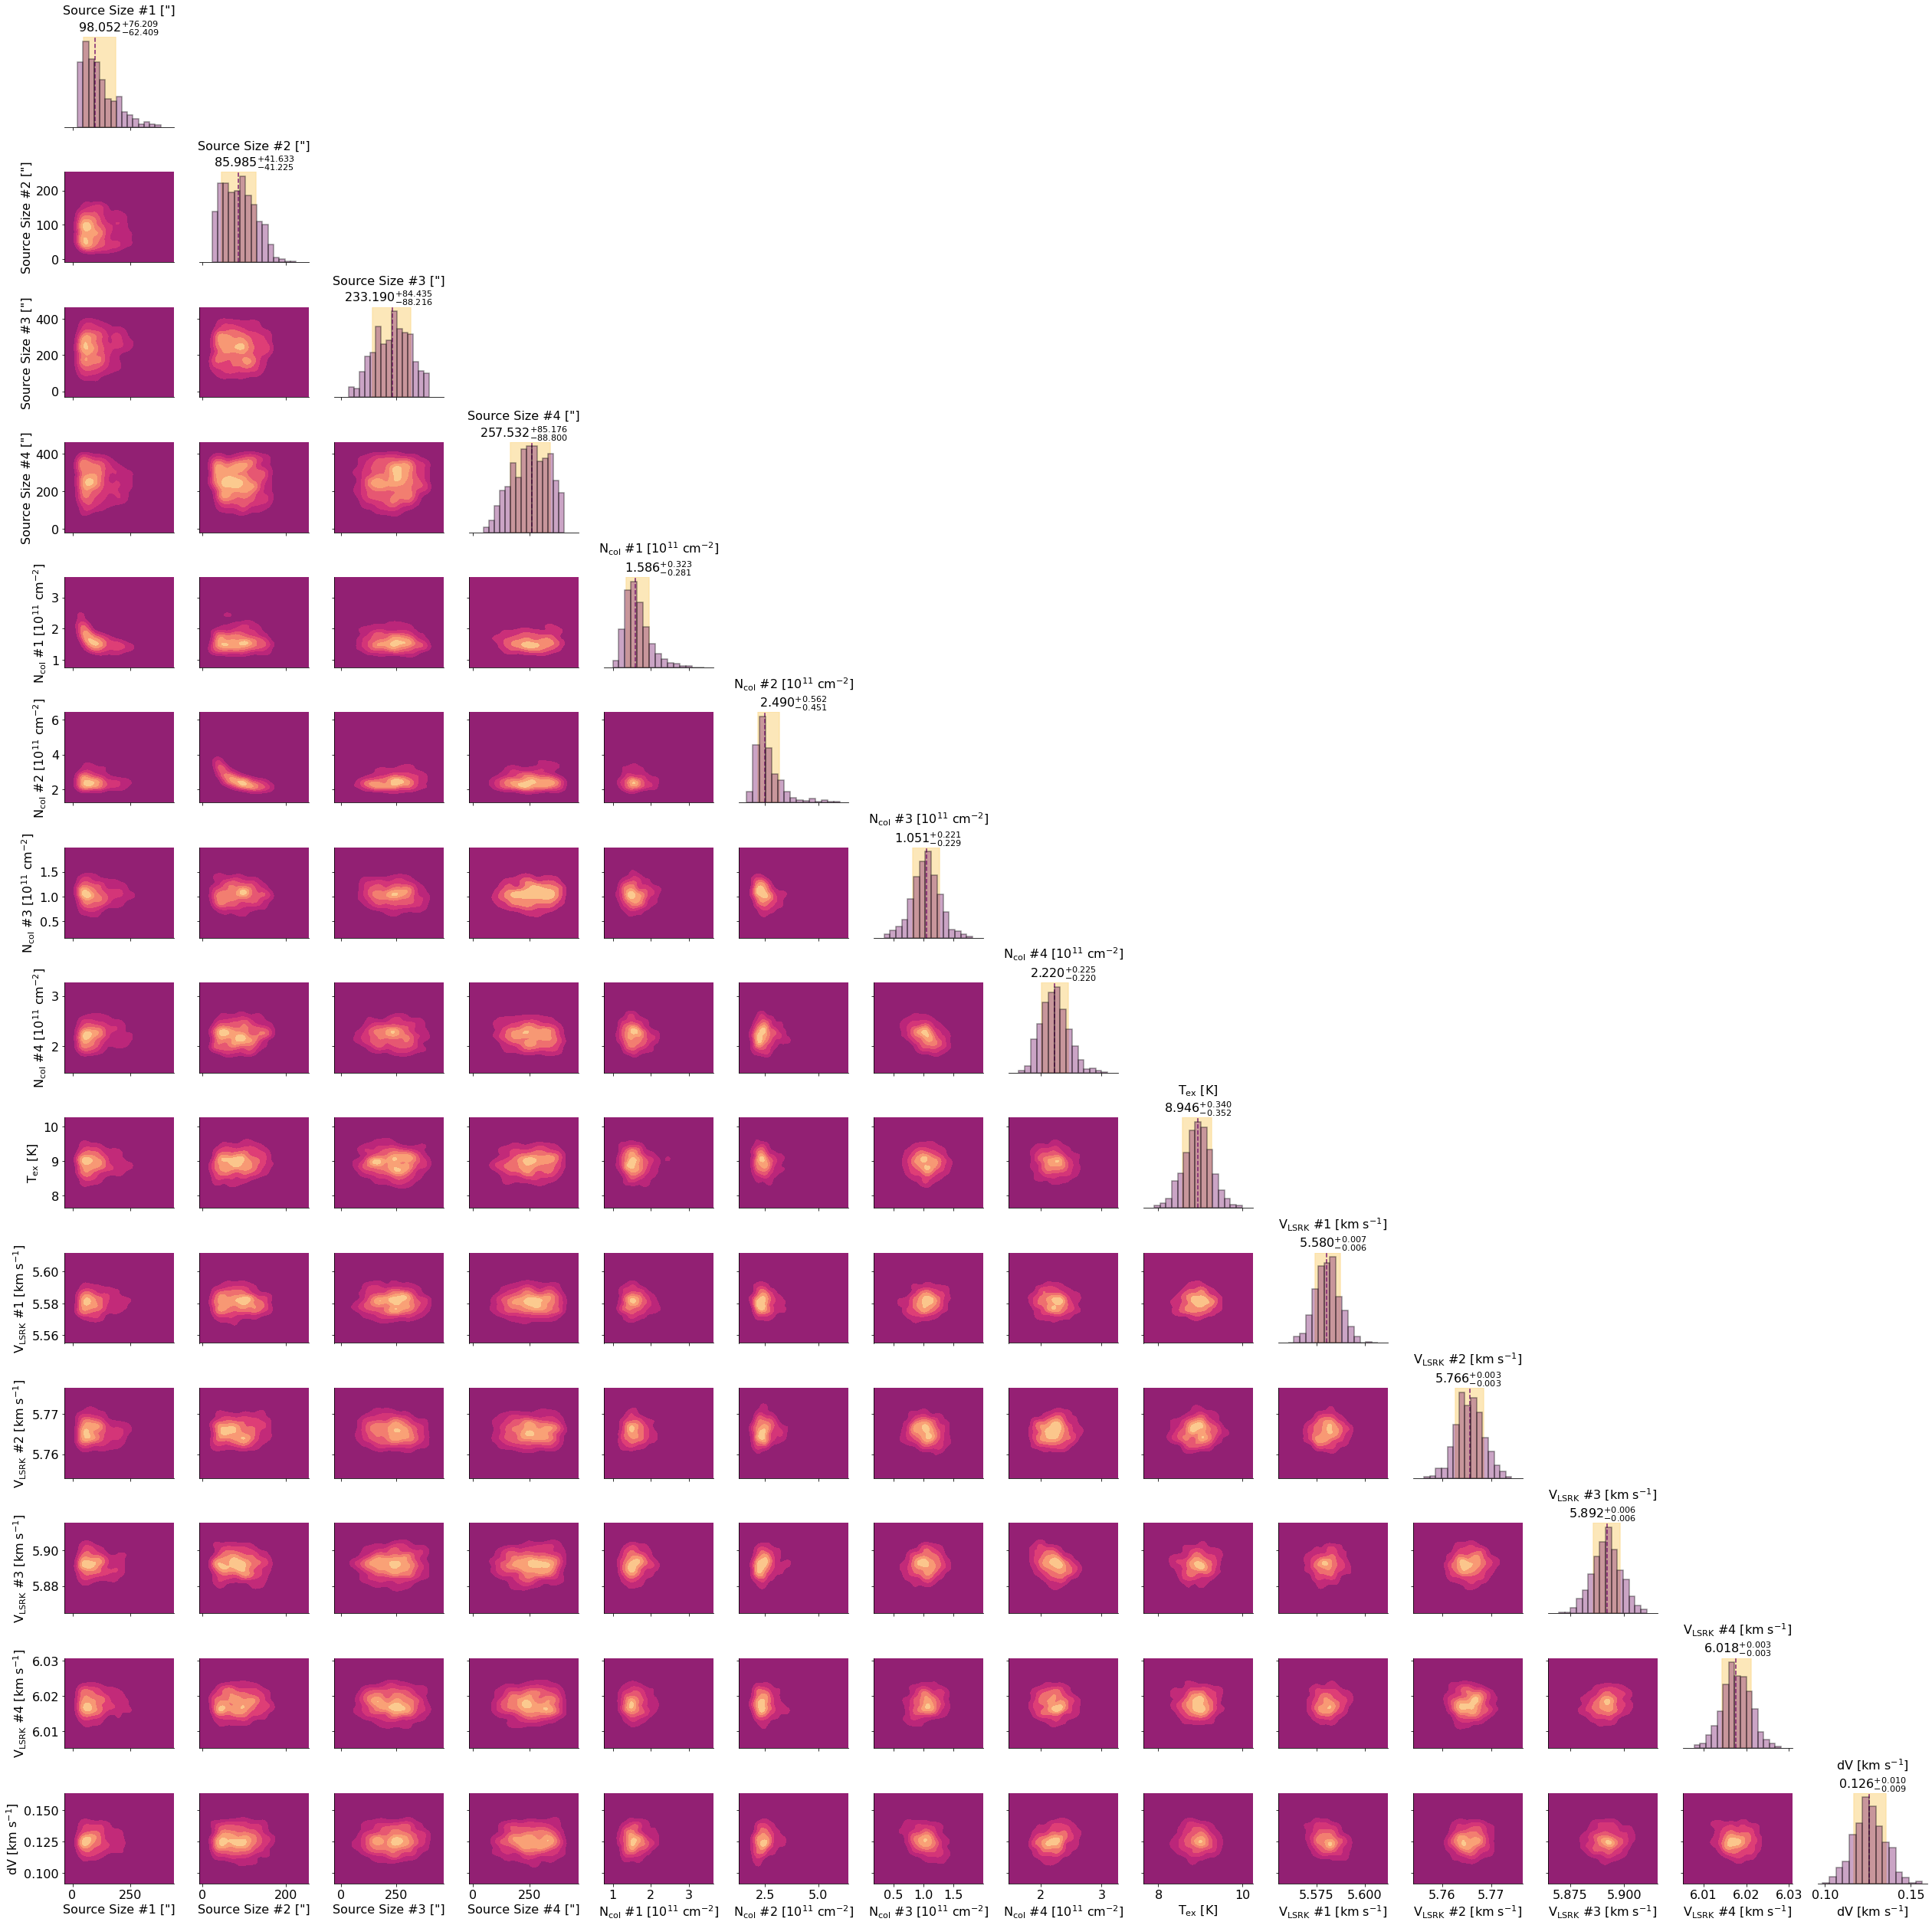

In [53]:
grid = sns.PairGrid(samples, corner=True, diag_sharey=False)
# grid.map_diag(sns.distplot, kde=False, color=top_color, norm_hist=True)# cumulative=False)
grid.map_diag(plt.hist, bins=15, color=top_color, linewidth=1.5, edgecolor="k", alpha=0.4, zorder=10)
grid.map_lower(sns.kdeplot, shade=True, shade_lowest=True, cmap=SunsetDark_6_r.get_mpl_colormap(), n_levels=6)
# loop over the diagonal of the corner plot, which are CDFs. We want to annotate
# the percentiles in this plot
for index, ax in enumerate(grid.diag_axes):
    name = param_names[index]
    param_stats = np.copy(summary_stats[:,index])
    # draw the region comprising 16th to 84th percentiles
    ax.axvspan(
        min(param_stats),
        max(param_stats),
        lw=1.5,
        color=bottom_color,
        facecolor="k",
        alpha=0.7,
        zorder=2
    )
    ranges = param_stats - param_stats.mean()
    ax.axvline(param_stats[1], lw=1.5, ls="--", color=top_color)
    # format the percentile stats in the title. This is somewhat of a pain because
    # we are combining LaTeX strings with Python f-strings
    lower_text = r"_\mathrm{" + f"{ranges[0]:.3f}" + r"}"
    upper_text = r"^\mathrm{" + f"+{ranges[-1]:.3f}" + r"}$"
    middle_text = f"{param_stats[1]:.3f}"
    ax.set_title(
        f"{name}\n" + r"$" + middle_text + lower_text + upper_text, fontsize=16
    )

grid.fig.tight_layout()

In [54]:
grid.fig.savefig("1-cnn_corner.pdf", dpi=300, transparent=True)